# Neural Prophet
[NeuralProphet](https://neuralprophet.com/model-overview/) is a Neural Network wich can do single step and multi step-ahead forecasts. It is a decomposable time series model with the components, trend, seasonality, auto-regression, special events, future regressors and lagged regressors. 

In the first part of this notebook Neural Prophet without external variables will be used to forcast the dengue cases, based on the trend, seasonality and autoregression. Seasonality is modelled using fourier terms, while auto-regression is handled using an implementation of AR-Net, an Auto-Regressive Feed-Forward Neural Network for time series.

In the second part of this notebook, another set of models will be build were the environmental features are included as future regressors. FIn Neural Prophet future regressors are external variables which have known future values for the forecast period. 

### Setup 

In [1]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed

# load self-written functions
from own_functions import model_classification
from own_functions import log_cases

from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

In [2]:
# set dictionary to access colors
colors= {'actual_weekly':'#a2bffe',
         'actual_monthly':'#26538d',
         'predicted_weekly':'coral',
         'predicted_monthly':'sienna'}

In [3]:
# load data
data_subsets_features = pickle.load(open('data_subsets_lags.pickle', 'rb'))

sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = data_subsets_features

In [4]:
# get log of cases as column
sj_train_train = log_cases(sj_train_train)
sj_train_test = log_cases(sj_train_test)
iq_train_train = log_cases(iq_train_train)
iq_train_test = log_cases(iq_train_test)

In [5]:
# set random state
set_random_seed(42)

In [6]:
# matplotlib configuration for plots within the notebook
plt.rcParams['figure.figsize'] = [10, 5]

# Part 1: Simple Neural Prophet (without future regressors)

## San Juan: Total cases (non-transformed)

In [7]:
# convert test data into a Prophet readable shape/configuration
sj_prophet_df_test = pd.DataFrame(sj_train_test.total_cases).reset_index()
sj_prophet_df_test.columns = ['ds', 'y']

# convert train data into a Prophet readable shape/configuration
sj_prophet_df = pd.DataFrame(sj_train_train.dropna().total_cases).reset_index()
sj_prophet_df.columns = ['ds', 'y']

In [9]:
# setup and fitting of the Neural Prophet model
sj_m = NeuralProphet(n_changepoints=0,
                     epochs=100,
                     weekly_seasonality=False, 
                     daily_seasonality=False,
                     seasonality_mode='multiplicative',
                     num_hidden_layers=2)
metrics = sj_m.fit(sj_prophet_df, freq="W", validate_each_epoch=True, epochs=100)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-02
Epoch[100/100]: 100%|█| 100/100 [00:05<00:00, 17.69it/s, SmoothL1Loss=0.101, MAE=28, RegLoss=0, MAE_val=10.8, S


### Diagnostic plots

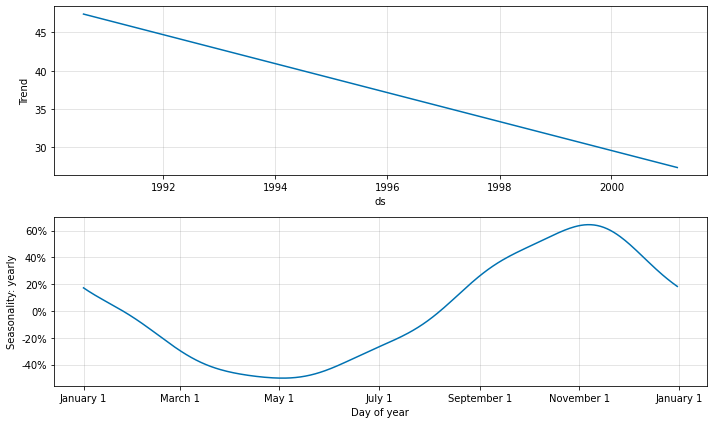

In [10]:
fig_param = sj_m.plot_parameters()

### Forecasting

In [11]:
# setup dataframe for forecasts
sj_future = sj_m.make_future_dataframe(sj_prophet_df, periods=233)

# add actual values from train_test (not used, just for plotting)
sj_future['y'] = sj_prophet_df_test['y']

# make predictions
sj_forecast = sj_m.predict(sj_future)

# convert negative values to zero (no negative prediction possible)
sj_forecast['yhat1'] = sj_forecast['yhat1'].clip(lower=0.0)

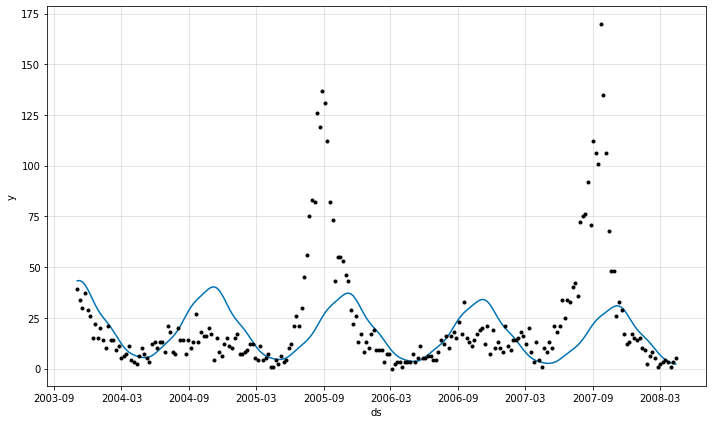

In [12]:
forecasts_plot = sj_m.plot(sj_forecast)

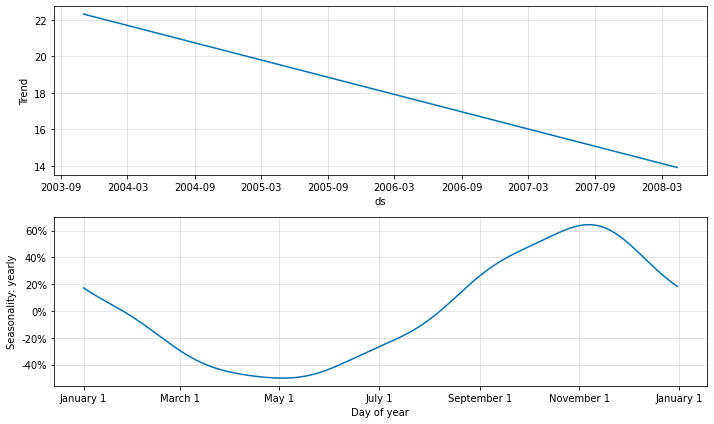

In [13]:
# diagnostic plots for forecast
fig_comp = sj_m.plot_components(sj_forecast)

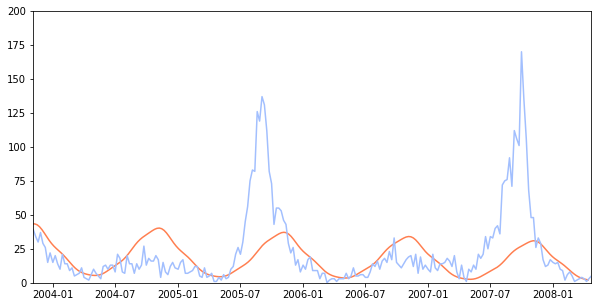

In [14]:
# plot predicted and actual values
plt.plot(sj_forecast.ds, sj_forecast.yhat1, color=colors['predicted_weekly'])
plt.plot(sj_train_test.index, sj_train_test.total_cases, colors['actual_weekly'])
plt.xlim(sj_train_test.index[0], sj_train_test.index[-1]);
plt.ylim(0,200);

In [15]:
# get model evaluation
model_classification(sj_train_test.total_cases, sj_forecast.yhat1)

--------------------
RMSE: 27.67
--------------------
MAE: 15.78
Explained variance: 0.087
--------------------


## San Juan: Total cases (log-transformed)

### Logged total cases

In [16]:
# convert test data into a Prophet readable shape/configuration
sj_prophet_df_test_log = pd.DataFrame(sj_train_test.logged_cases).reset_index()
sj_prophet_df_test_log.columns = ['ds', 'y']

# convert train data into a Prophet readable shape/configuration
sj_prophet_df_log = pd.DataFrame(sj_train_train.dropna().logged_cases).reset_index()
sj_prophet_df_log.columns = ['ds', 'y']

In [17]:
# setup and fitting of the Neural Prophet model
sj_m_log = NeuralProphet(n_changepoints=0,
                         epochs=100,
                         weekly_seasonality=False, 
                         daily_seasonality=False,
                         seasonality_mode='multiplicative',
                         num_hidden_layers=2
                        )
metrics = sj_m_log.fit(sj_prophet_df_log, freq="W", validate_each_epoch=True)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
Epoch[100/100]: 100%|█| 100/100 [00:05<00:00, 18.05it/s, SmoothL1Loss=0.0101, MAE=0.611, RegLoss=0, MAE_val=0.6


### Diagnostic plots

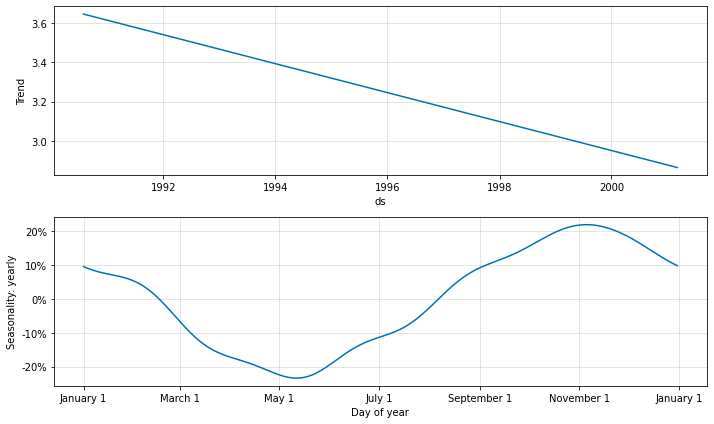

In [18]:
fig_param = sj_m_log.plot_parameters()

### Forecasting

In [19]:
# setup dataframe for forecasts
sj_future_log = sj_m_log.make_future_dataframe(sj_prophet_df_log, periods=233)

# add actual values from train_test (not used, just for plotting)
sj_future_log['y'] = sj_prophet_df_test_log['y']

# make predictions
sj_forecast_log = sj_m_log.predict(sj_future_log)

# convert negative values to zero (no negative prediction possible)
sj_forecast_log['yhat1'] = sj_forecast_log['yhat1'].clip(lower=0.0)

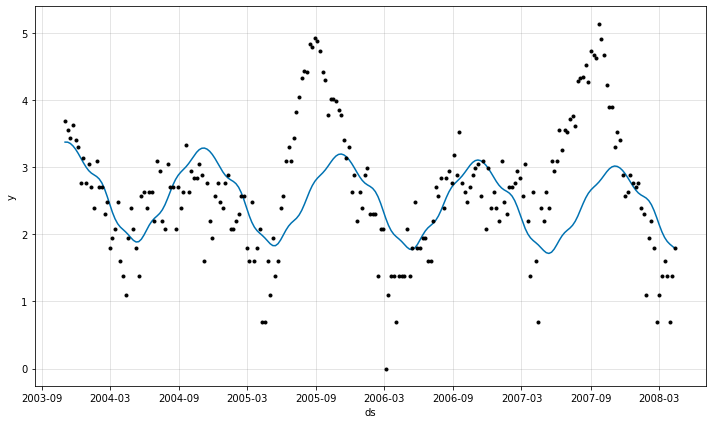

In [20]:
forecasts_plot = sj_m_log.plot(sj_forecast_log)

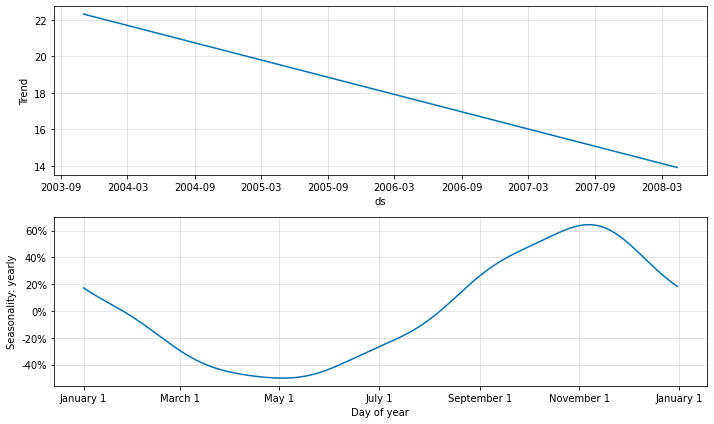

In [21]:
# diagnostic plots for predictions
fig_comp = sj_m.plot_components(sj_forecast)

### Evaluation

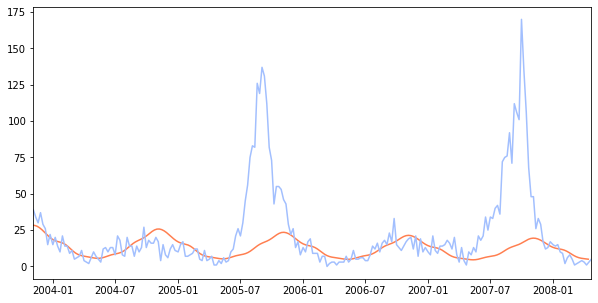

In [22]:
# get log-values back to normal scale
sj_pred_log = np.exp(sj_forecast_log.yhat1)-1

# plot predicted and actual values
plt.plot(sj_forecast_log.ds, sj_pred_log, color=colors['predicted_weekly'])
plt.plot(sj_train_test.index, sj_train_test.total_cases, color=colors['actual_weekly'])
plt.xlim(sj_train_test.index[0], sj_train_test.index[-1]);

In [23]:
# model evaluation
model_classification(sj_train_test.total_cases, sj_pred_log)

--------------------
RMSE: 29.51
--------------------
MAE: 14.51
Explained variance: 0.053
--------------------


## Iquitos: Total cases (non-transformed)

In [24]:
# convert test data into a Prophet readable shape/configuration
iq_prophet_df_test = pd.DataFrame(iq_train_test.total_cases).reset_index()
iq_prophet_df_test.columns = ['ds', 'y']

# convert train data into a Prophet readable shape/configuration
iq_prophet_df = pd.DataFrame(iq_train_train.dropna().total_cases).reset_index()
iq_prophet_df.columns = ['ds', 'y']

In [25]:
# setup and fitting of the Neural Prophet model
iq_m = NeuralProphet(n_changepoints=0,
                     epochs=100,
                     weekly_seasonality=False, 
                     daily_seasonality=False,
                     seasonality_mode='multiplicative',
                     num_hidden_layers=2)
metrics = iq_m.fit(iq_prophet_df, freq="W", validate_each_epoch=True)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-02
Epoch[100/100]: 100%|█| 100/100 [00:02<00:00, 35.87it/s, SmoothL1Loss=0.0628, MAE=5.84, RegLoss=0, MAE_val=6.74


### Diagnostic plots

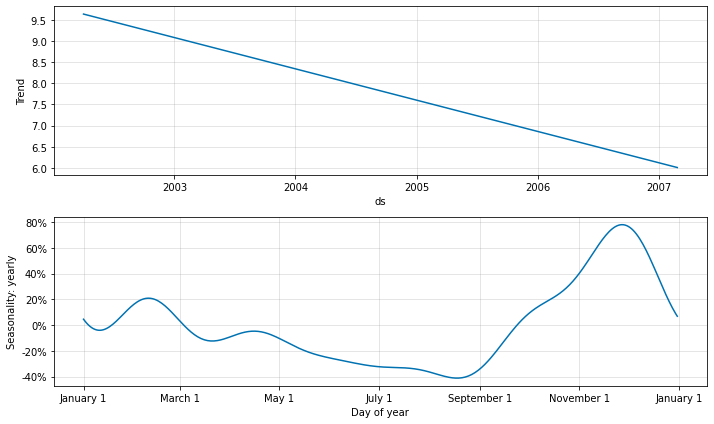

In [26]:
fig_param = iq_m.plot_parameters()

### Forecasting

In [27]:
# setup dataframe for forecasts
iq_future = iq_m.make_future_dataframe(iq_prophet_df, periods=110)

# add actual values from train_test (not used, just for plotting)
iq_future['y'] = iq_prophet_df_test['y']

# make predictions
iq_forecast = iq_m.predict(iq_future)

# convert negative values to zero (no negative prediction possible)
iq_forecast['yhat1'] = iq_forecast['yhat1'].clip(lower=0.0)

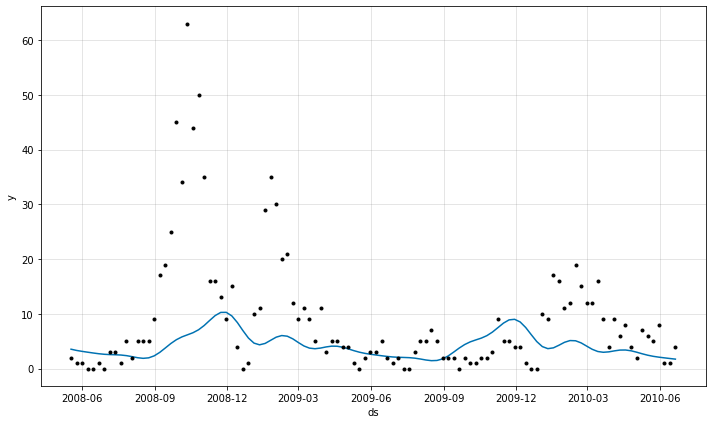

In [28]:
forecasts_plot = iq_m.plot(iq_forecast)

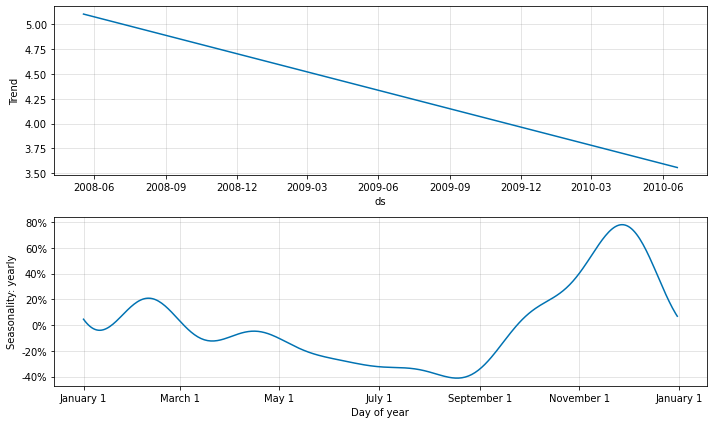

In [29]:
# diagnostic plots for predictions
fig_comp = iq_m.plot_components(iq_forecast)

### Evaluation

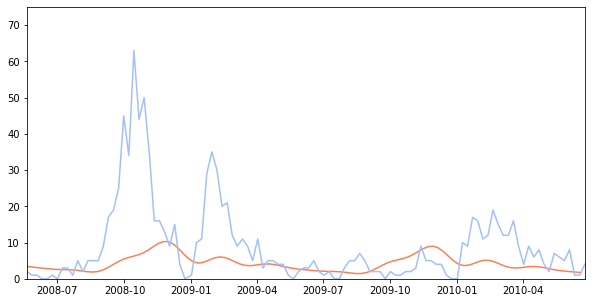

In [30]:
# plot predicted and actual values
plt.plot(iq_forecast.ds, iq_forecast.yhat1, color=colors['predicted_weekly'])
plt.plot(iq_train_test.index, iq_train_test.total_cases, color=colors['actual_weekly'])
plt.xlim(iq_train_test.index[0], iq_train_test.index[-1]);
plt.ylim(0,75);

In [31]:
# model evaluation
model_classification(iq_train_test.total_cases, iq_forecast.yhat1)

--------------------
RMSE: 11.74
--------------------
MAE: 6.84
Explained variance: 0.099
--------------------


## Iquitos: Total cases (log-transformed)

In [32]:
# convert test data into a Prophet readable shape/configuration
iq_prophet_df_test_log = pd.DataFrame(iq_train_test.logged_cases).reset_index()
iq_prophet_df_test_log.columns = ['ds', 'y']

# convert train data into a Prophet readable shape/configuration
iq_prophet_df_log = pd.DataFrame(iq_train_train.dropna().logged_cases).reset_index()
iq_prophet_df_log.columns = ['ds', 'y']

In [33]:
# setup and fitting of the Neural Prophet model
iq_m_log = NeuralProphet(n_changepoints=0,
                         epochs=100,
                         weekly_seasonality=False, 
                         daily_seasonality=False,
                         seasonality_mode='multiplicative',
                         num_hidden_layers=2)
metrics = iq_m_log.fit(iq_prophet_df_log, freq="W", validate_each_epoch=True)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[100/100]: 100%|█| 100/100 [00:02<00:00, 35.99it/s, SmoothL1Loss=0.0253, MAE=0.694, RegLoss=0, MAE_val=0.6


### Diagnostic plots

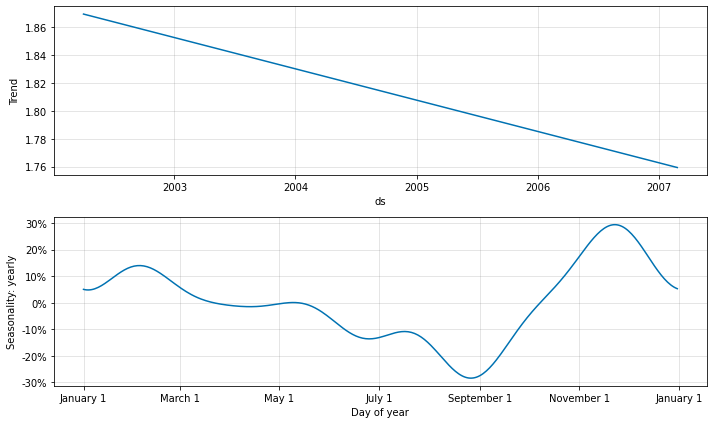

In [34]:
fig_param = iq_m_log.plot_parameters()

### Forecasting

In [35]:
# setup dataframe for forecasts
iq_future_log = iq_m.make_future_dataframe(iq_prophet_df_log, periods=110)

# add actual values from train_test (not used, just for plotting)
iq_future_log['y'] = iq_prophet_df_test_log['y']

# make predictions
iq_forecast_log = iq_m_log.predict(iq_future_log)

# convert negative values to zero (no negative prediction possible)
iq_forecast_log['yhat1'] = iq_forecast_log['yhat1'].clip(lower=0.0)

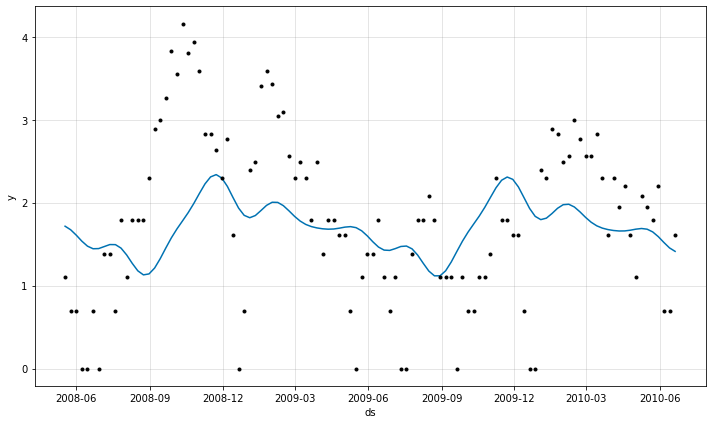

In [36]:
forecasts_plot = iq_m_log.plot(iq_forecast_log)

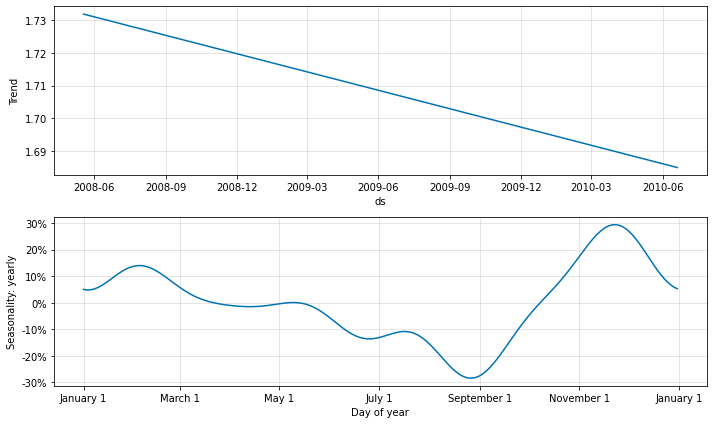

In [37]:
# diagnostic plots for predictions
fig_comp = iq_m_log.plot_components(iq_forecast_log)

### Evaluation

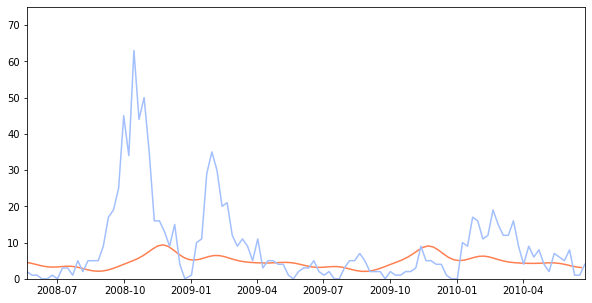

In [38]:
# get log-values back to normal scale
iq_pred_log = np.exp(iq_forecast_log.yhat1)-1

# plot predicted and actual values
plt.plot(iq_forecast_log.ds, iq_pred_log, colors['predicted_weekly'])
plt.plot(iq_train_test.index, iq_train_test.total_cases, colors['actual_weekly'])
plt.xlim(iq_train_test.index[0], iq_train_test.index[-1]);
plt.ylim(0,75);

In [39]:
# model evaluation
model_classification(iq_train_test.total_cases, iq_pred_log)

--------------------
RMSE: 11.77
--------------------
MAE: 6.68
Explained variance: 0.057
--------------------


---
# Part 2: Neural Prophet with future regressors

In [40]:
# get a with names of future regressors 
future_regressors = sj_train_train.columns.tolist()
not_features = ['logged_cases', 'total_cases', 'month', 'weekofyear', 'year', 'week_start_date', 'city', ]
future_regressors = [x for x in future_regressors if x not in not_features]

## San Juan (total cases)

In [117]:
# create prophet compatible dataframe
sj_prophet_df_ex = pd.DataFrame(sj_train_train.dropna().total_cases).reset_index()
sj_prophet_df_ex.columns = ['ds', 'y']

# add external variables (=future regressors)
sj_prophet_df_ex = pd.concat([sj_prophet_df_ex, sj_train_train.dropna()[future_regressors].reset_index()], axis=1)
sj_prophet_df_ex = sj_prophet_df_ex.drop('index', axis=1)

In [118]:
# future regressors for forecast
sj_future_regressors_df = sj_train_test.dropna()[future_regressors]

In [126]:
# setup and fit the model
sj_m_ex = NeuralProphet(n_changepoints=0,
                        epochs=100,
                        weekly_seasonality=False, 
                        daily_seasonality=False,
                        seasonality_reg=0.65,
                        num_hidden_layers=2)

# add future regressors
for regressor in future_regressors:
    sj_m_ex = sj_m_ex.add_future_regressor(name=regressor) 

metrics = sj_m_ex.fit(sj_prophet_df_ex, freq="W", validate_each_epoch=True)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
Epoch[100/100]: 100%|█| 100/100 [00:08<00:00, 11.55it/s, SmoothL1Loss=0.0743, MAE=25.1, RegLoss=0.0011, MAE_val


### Diagnostic plots

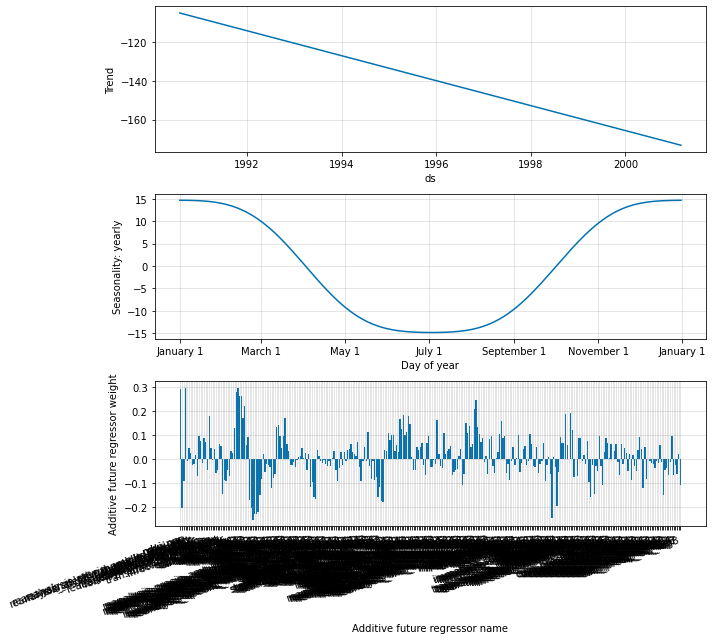

In [127]:
fig_param = sj_m_ex.plot_parameters()

### Forecasting

In [128]:
# setup dataframe for forecasts
sj_future_ex = sj_m_ex.make_future_dataframe(df=sj_prophet_df_ex, regressors_df=sj_future_regressors_df, periods=233)

# add actual values from train_test (not used, just for plotting)
sj_future_ex['y'] = sj_prophet_df_test['y']

# make predictions
sj_forecast_ex = sj_m_ex.predict(df=sj_future_ex)

# convert negative values to zero (no negative prediction possible)
sj_forecast_ex['yhat1'] = sj_forecast_ex['yhat1'].clip(lower=0.0)

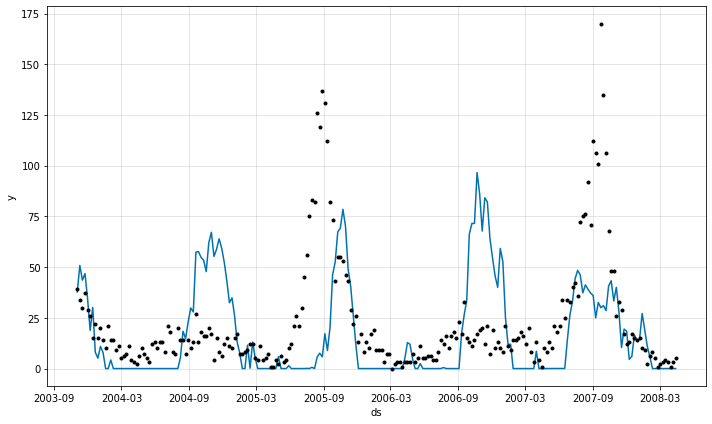

In [129]:
forecasts_plot = sj_m_ex.plot(sj_forecast_ex)

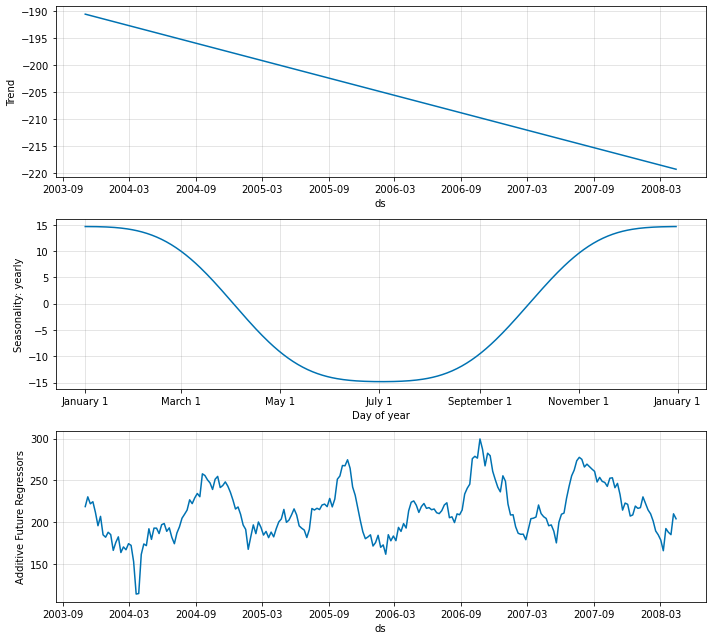

In [130]:
# diagnostic plots for predictions
fig_comp = sj_m_ex.plot_components(sj_forecast_ex)

### Evaluation

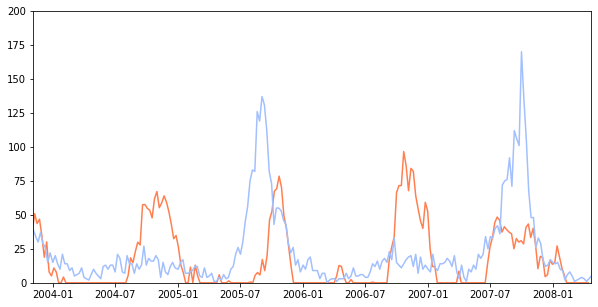

In [131]:
# plot actual and predicted values
plt.plot(sj_forecast_ex.ds, sj_forecast_ex.yhat1, color=colors['predicted_weekly'])
plt.plot(sj_train_test.index, sj_train_test.total_cases, color=colors['actual_weekly'])
plt.xlim(sj_train_test.index[0], sj_train_test.index[-1]);
plt.ylim(0,200);

In [132]:
# model evaluation
model_classification(sj_train_test.total_cases, sj_forecast_ex.yhat1)

--------------------
RMSE: 32.71
--------------------
MAE: 20.56
Explained variance: -0.267
--------------------


## San Juan: Total cases (log-transformed)

In [133]:
# create prophet compatible dataframe
sj_prophet_df_ex_log = pd.DataFrame(sj_train_train.dropna().logged_cases).reset_index()
sj_prophet_df_ex_log.columns = ['ds', 'y']
# add external variables (=future regressors)
sj_prophet_df_ex_log = pd.concat([sj_prophet_df_ex_log, sj_train_train.dropna()[future_regressors].reset_index()], axis=1)
sj_prophet_df_ex_log = sj_prophet_df_ex_log.drop('index', axis=1)

In [134]:
# future regressors for forecast
sj_future_regressors_df = sj_train_test.dropna()[future_regressors]

In [135]:
# setup and fit the model
sj_m_ex_log = NeuralProphet(n_changepoints=0,
                            epochs=100,
                            weekly_seasonality=False, 
                            daily_seasonality=False,
                            seasonality_mode='multiplicative',
                            seasonality_reg=10, 
                            num_hidden_layers=2)

# add future regressors
for regressor in future_regressors:
    sj_m_ex_log = sj_m_ex_log.add_future_regressor(name=regressor) #, regularization=0.0)

metrics = sj_m_ex_log.fit(sj_prophet_df_ex_log, freq="W", validate_each_epoch=True)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-02
Epoch[100/100]: 100%|█| 100/100 [00:08<00:00, 11.97it/s, SmoothL1Loss=0.00469, MAE=0.423, RegLoss=1.22e-6, MAE_


### Diagnostic plots

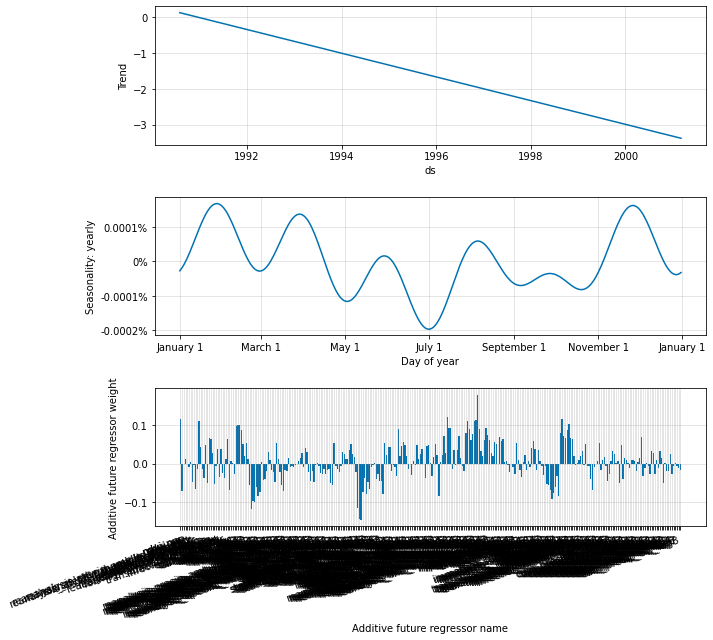

In [136]:
fig_param = sj_m_ex_log.plot_parameters()

### Forecasting

In [137]:
# setup dataframe for forecasts
sj_future_ex_log = sj_m_ex_log.make_future_dataframe(df=sj_prophet_df_ex_log, regressors_df=sj_future_regressors_df, periods=233)

# add actual values from train_test (not used, just for plotting)
sj_future_ex_log['y'] = sj_prophet_df_test_log['y']

# make predictions
sj_forecast_ex_log = sj_m_ex_log.predict(df=sj_future_ex_log)

# convert negative values to zero (no negative prediction possible)
sj_forecast_ex_log['yhat1'] = sj_forecast_ex_log['yhat1'].clip(lower=0.0)

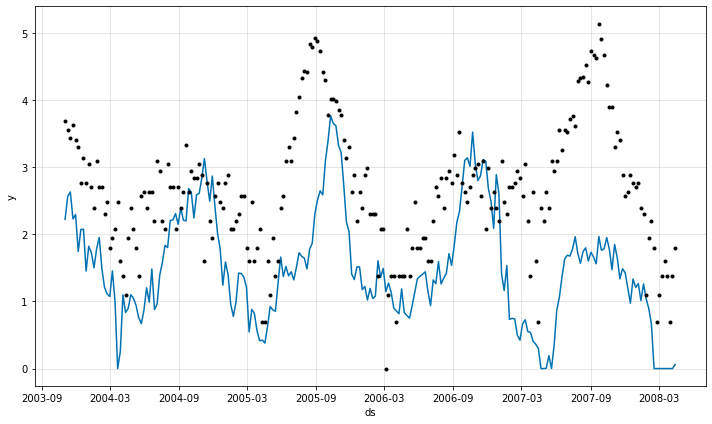

In [138]:
forecasts_plot = sj_m_ex_log.plot(sj_forecast_ex_log)

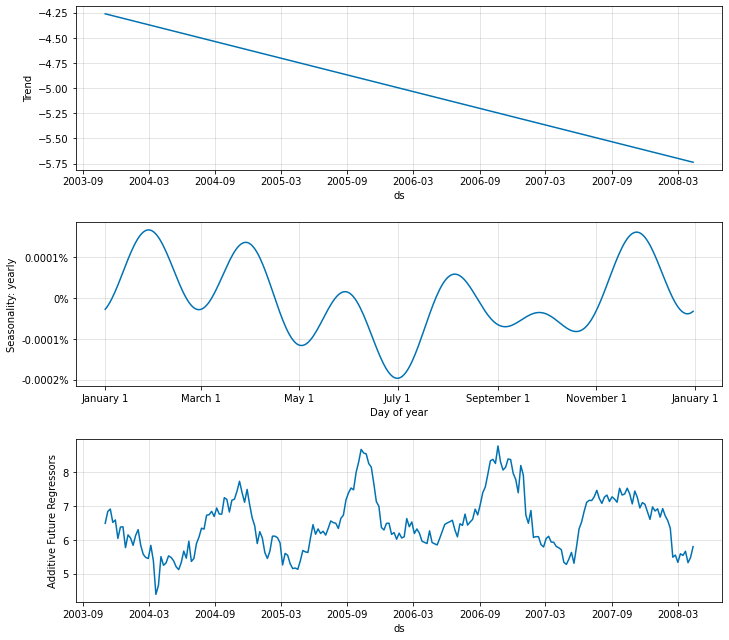

In [139]:
# diagnostic plots for predictions
fig_comp = sj_m_ex_log.plot_components(sj_forecast_ex_log)

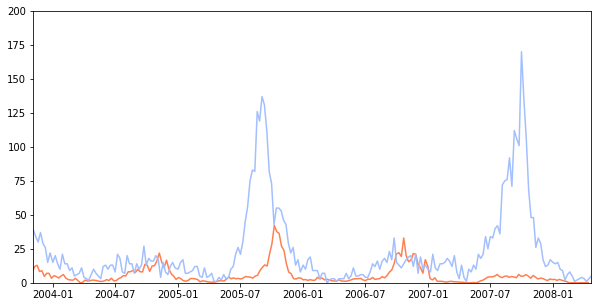

In [140]:
# get log-values back to normal scale
sj_pred_ex_log = np.exp(sj_forecast_ex_log.yhat1)-1

# plot actual and predicted values
plt.plot(sj_forecast.ds, sj_pred_ex_log, color=colors['predicted_weekly'])
plt.plot(sj_train_test.index, sj_train_test.total_cases, color=colors['actual_weekly'])
plt.xlim(sj_train_test.index[0], sj_train_test.index[-1]);
plt.ylim(0,200);

In [141]:
# model evaluation
model_classification(sj_train_test.total_cases, sj_pred_ex_log)

--------------------
RMSE: 32.62
--------------------
MAE: 18.03
Explained variance: 0.054
--------------------


## Iquitos: Total cases (non-transformed)

In [64]:
# create prophet compatible dataframe
iq_prophet_df_ex = pd.DataFrame(iq_train_train.dropna().total_cases).reset_index()
iq_prophet_df_ex.columns = ['ds', 'y']
# add external variables (=future regressors)
iq_prophet_df_ex = pd.concat([iq_prophet_df_ex, iq_train_train.dropna()[future_regressors].reset_index()], axis=1)
iq_prophet_df_ex = iq_prophet_df_ex.drop('index', axis=1)

In [65]:
# future regressors for forecast
iq_future_regressors_df = iq_train_test.dropna()[future_regressors]

In [66]:
# setup and fit the model
iq_m_ex = NeuralProphet(n_changepoints=0,
                        epochs=100,
                        weekly_seasonality=False, 
                        daily_seasonality=False,
                        seasonality_mode='multiplicative',
                        num_hidden_layers=2)

# add future regressors
for regressor in future_regressors:
    iq_m_ex = iq_m_ex.add_future_regressor(name=regressor)

metrics = iq_m_ex.fit(iq_prophet_df_ex, freq="W", validate_each_epoch=True)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-01
Epoch[100/100]: 100%|█| 100/100 [00:03<00:00, 25.96it/s, SmoothL1Loss=0.0354, MAE=4.07, RegLoss=0, MAE_val=9.57


### Diagnostic plots

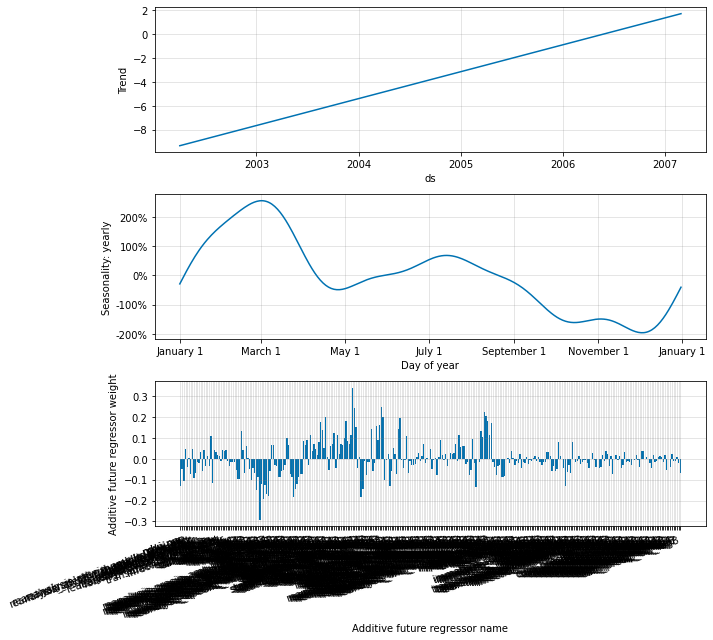

In [67]:
fig_param = iq_m_ex.plot_parameters()

### Forecasting

In [68]:
# setup dataframe for forecasts
iq_future_ex = iq_m_ex.make_future_dataframe(df=iq_prophet_df_ex, regressors_df=iq_future_regressors_df, periods=110)

# add actual values from train_test (not used, just for plotting)
iq_future_ex['y'] = iq_prophet_df_test['y']

# make predictions
iq_forecast_ex = iq_m_ex.predict(df=iq_future_ex)

# convert negative values to zero (no negative prediction possible)
iq_forecast_ex['yhat1'] = iq_forecast_ex['yhat1'].clip(lower=0.0)

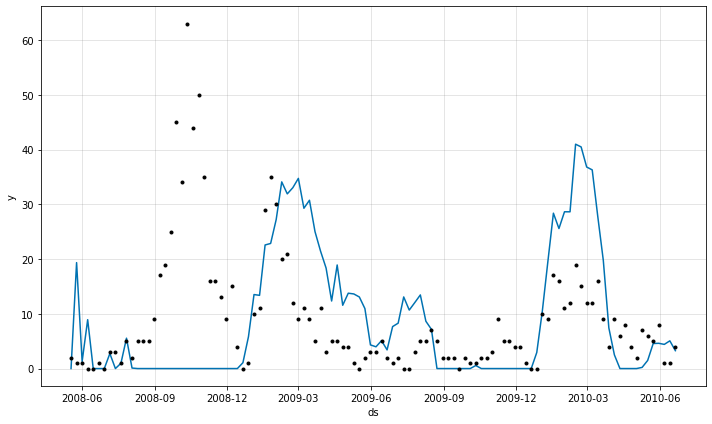

In [69]:
forecasts_plot = iq_m_ex.plot(iq_forecast_ex)

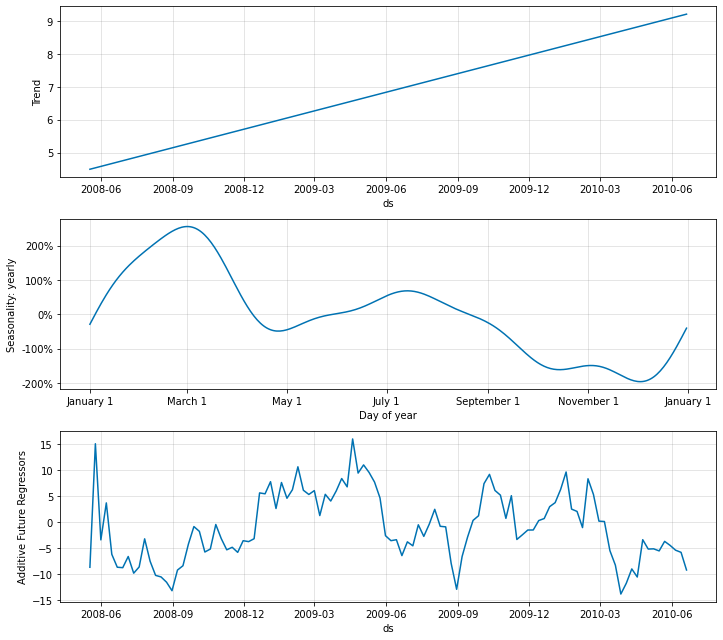

In [70]:
# diagnostic plots for predictions
fig_comp = iq_m_ex.plot_components(iq_forecast_ex)

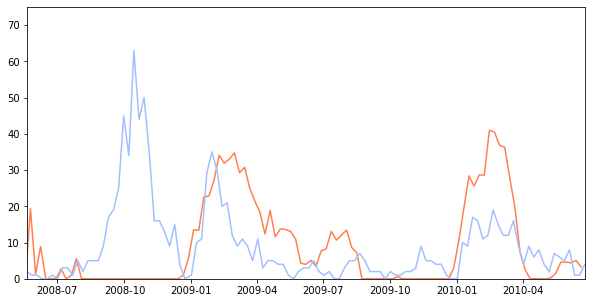

In [71]:
# plot actual and predicted values
plt.plot(iq_forecast_ex.ds, iq_forecast_ex.yhat1, color=colors['predicted_weekly'])
plt.plot(iq_train_test.index, iq_train_test.total_cases, color=colors['actual_weekly'])
plt.xlim(iq_train_test.index[0], iq_train_test.index[-1]);
plt.ylim(0,75);

In [72]:
# model evaluation
model_classification(iq_train_test.total_cases, iq_forecast_ex.yhat1)

--------------------
RMSE: 14.85
--------------------
MAE: 9.84
Explained variance: -0.734
--------------------


## Iquitos: Total cases (non-transformed)

In [73]:
# create prophet compatible dataframe
iq_prophet_df_ex_log = pd.DataFrame(iq_train_train.dropna().logged_cases).reset_index()
iq_prophet_df_ex_log.columns = ['ds', 'y']
# add external variables (=future regressors)
iq_prophet_df_ex_log = pd.concat([iq_prophet_df_ex_log, iq_train_train.dropna()[future_regressors].reset_index()], axis=1)
iq_prophet_df_ex_log = iq_prophet_df_ex_log.drop('index', axis=1)

In [74]:
# future regressors for forecast
iq_future_regressors_df = iq_train_test.dropna()[future_regressors]

In [75]:
# setup and fit model
iq_m_ex_log = NeuralProphet(n_changepoints=0,
                            epochs=100,
                            weekly_seasonality=False, 
                            daily_seasonality=False,
                            seasonality_mode='multiplicative',
                            seasonality_reg=5,
                            num_hidden_layers=2)

# add future regressors
for regressor in future_regressors:
    iq_m_ex_log = iq_m_ex_log.add_future_regressor(name=regressor)

metrics = iq_m_ex_log.fit(iq_prophet_df_ex_log, freq="W", validate_each_epoch=True)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-03
Epoch[100/100]: 100%|█| 100/100 [00:04<00:00, 23.50it/s, SmoothL1Loss=0.0155, MAE=0.532, RegLoss=1.98e-7, MAE_v


### Diagnostic plots

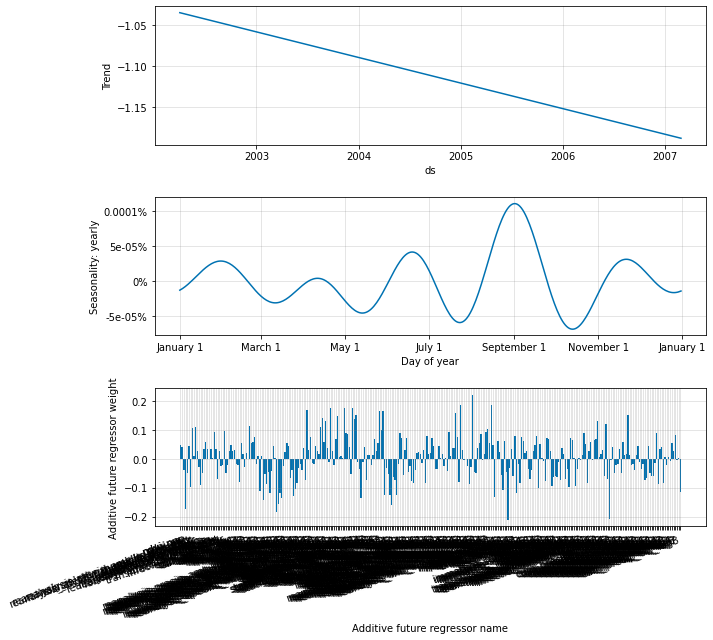

In [76]:
fig_param = iq_m_ex_log.plot_parameters()

### Forecasting

In [77]:
# setup dataframe for forecasts
iq_future_ex_log = iq_m_ex_log.make_future_dataframe(df=iq_prophet_df_ex_log, regressors_df=iq_future_regressors_df, periods=110)

# add actual values from train_test (not used, just for plotting)
iq_future_ex_log['y'] = iq_prophet_df_test_log['y']

# make predictions
iq_forecast_ex_log = iq_m_ex_log.predict(df=iq_future_ex_log)

# convert negative values to zero (no negative prediction possible)
iq_forecast_ex_log['yhat1'] = iq_forecast_ex_log['yhat1'].clip(lower=0.0)

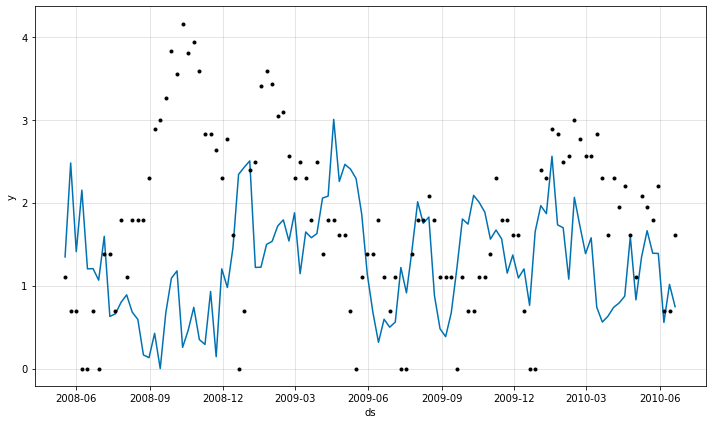

In [78]:
forecasts_plot = iq_m_ex_log.plot(iq_forecast_ex_log)

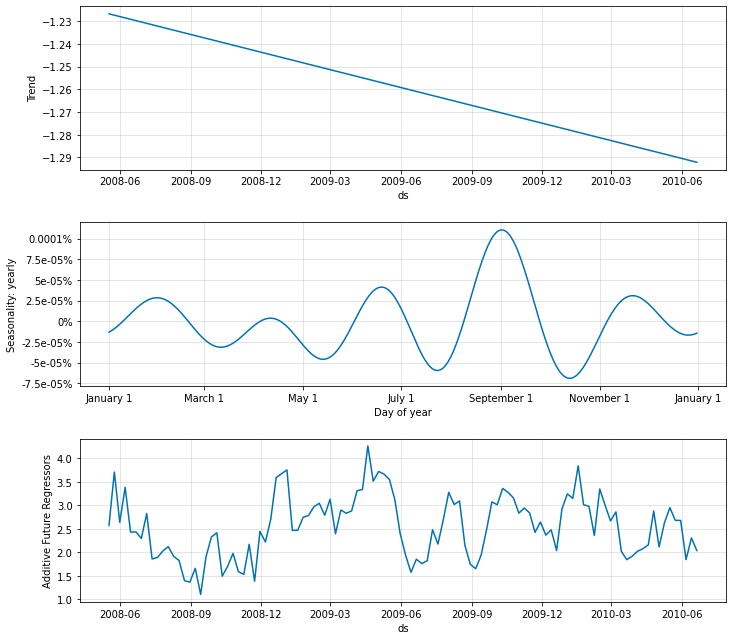

In [79]:
# diagnostic plots for predictions
fig_comp = iq_m_ex_log.plot_components(iq_forecast_ex_log)

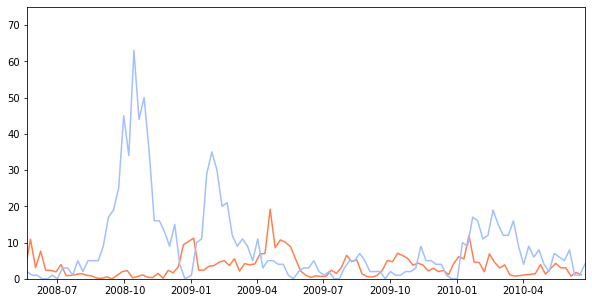

In [80]:
# get log-values back to normal scale
iq_pred_ex_log = np.exp(iq_forecast_ex_log.yhat1)-1

# plot actual and predicted values
plt.plot(iq_forecast_ex.ds, iq_pred_ex_log, color=colors['predicted_weekly'])
plt.plot(iq_train_test.index, iq_train_test.total_cases, color=colors['actual_weekly'])
plt.xlim(iq_train_test.index[0], iq_train_test.index[-1]);
plt.ylim(0,75);

In [81]:
# model evaluation
model_classification(iq_train_test.total_cases, iq_pred_ex_log)

--------------------
RMSE: 13.45
--------------------
MAE: 8.04
Explained variance: -0.18
--------------------


# With only a subset of future regressors
## San Juan: Total cases (log-transformed)

### Feature selection

In [82]:
# get pearson correlation and get the 15 features with highest correlation
corr_mat = sj_train_train.corr()
cases_corr_list = (
    corr_mat['logged_cases']
    .drop(['logged_cases', 'total_cases', 'month', 'weekofyear', 'year'], axis=0)
    .abs()
    .sort_values(ascending=False)
)
cases_corr_list[:15]

reanalysis_specific_humidity_g_per_kg_lag8    0.500258
reanalysis_dew_point_temp_c_lag8              0.497561
reanalysis_specific_humidity_g_per_kg_lag7    0.476806
reanalysis_dew_point_temp_c_lag7              0.473338
station_avg_temp_c_lag8                       0.471419
reanalysis_min_air_temp_c_lag8                0.468035
fecundity_lag8                                0.461211
reanalysis_max_air_temp_c_lag8                0.459768
transmission_probability_lag8                 0.459302
station_min_temp_c_lag8                       0.459142
infection_probability_lag8                    0.459076
mdr_lag8                                      0.458294
biting_rate_lag8                              0.457633
pdr_lag8                                      0.456518
reanalysis_air_temp_c_lag8                    0.455948
Name: logged_cases, dtype: float64

In [83]:
# put 15 features with highest correlation in list
sj_exogs = cases_corr_list[:15].index.tolist()

### Setup model

In [84]:
# create prophet compatible dataframe
sj_prophet_df_ex_log1 = pd.DataFrame(sj_train_train.dropna().logged_cases).reset_index()
sj_prophet_df_ex_log1.columns = ['ds', 'y']
# add external variables (=future regressors)
sj_prophet_df_ex_log1 = pd.concat([sj_prophet_df_ex_log1, sj_train_train.dropna()[sj_exogs].reset_index()], axis=1)
sj_prophet_df_ex_log1 = sj_prophet_df_ex_log1.drop('index', axis=1)

In [85]:
# future regressors for forecast
sj_future_regressors_df1 = sj_train_test.dropna()[sj_exogs]

In [86]:
# set up model and fit 
sj_m_ex_log1 = NeuralProphet(n_changepoints=0,
                            epochs=100,
                            weekly_seasonality=False, 
                            daily_seasonality=False,
                            seasonality_mode='multiplicative',
                            num_hidden_layers=2)

# add future regressors
for regressor in sj_exogs:
    sj_m_ex_log1 = sj_m_ex_log1.add_future_regressor(name=regressor) #, regularization=0.0)

metrics = sj_m_ex_log1.fit(sj_prophet_df_ex_log1, freq="W", validate_each_epoch=True)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[100/100]: 100%|█| 100/100 [00:07<00:00, 13.03it/s, SmoothL1Loss=0.00867, MAE=0.563, RegLoss=0, MAE_val=0.


### Diagnostic plots

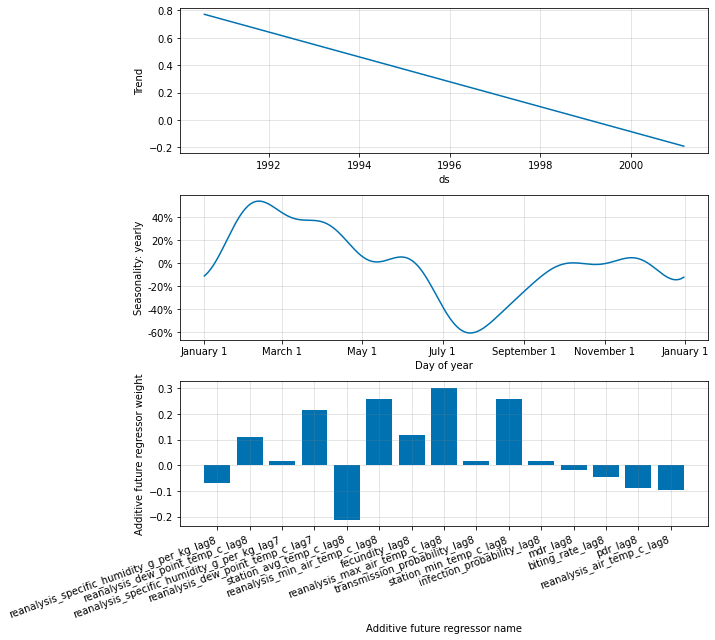

In [87]:
fig_param = sj_m_ex_log1.plot_parameters()

### Forecasting

In [88]:
# setup dataframe for forecasts
sj_future_ex_log1 = sj_m_ex_log1.make_future_dataframe(df=sj_prophet_df_ex_log1, regressors_df=sj_future_regressors_df1, periods=233)

# add actual values from train_test (not used, just for plotting)
sj_future_ex_log1['y'] = sj_prophet_df_test_log['y']

# make predictions
sj_forecast_ex_log1 = sj_m_ex_log1.predict(df=sj_future_ex_log1)

# convert negative values to zero (no negative prediction possible)
sj_forecast_ex_log1['yhat1'] = sj_forecast_ex_log1['yhat1'].clip(lower=0.0)

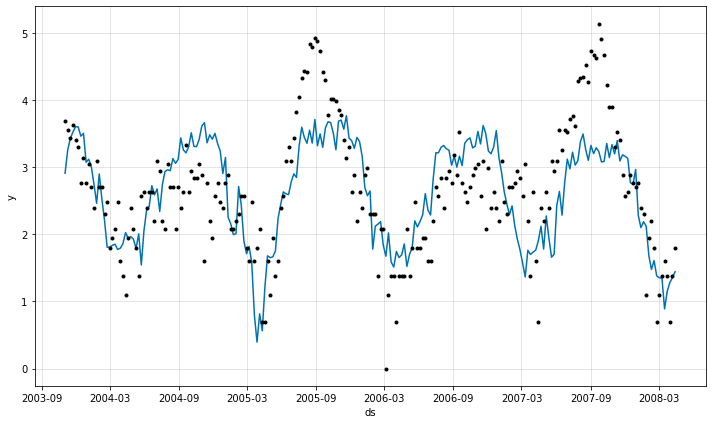

In [89]:
forecasts_plot = sj_m_ex_log1.plot(sj_forecast_ex_log1)

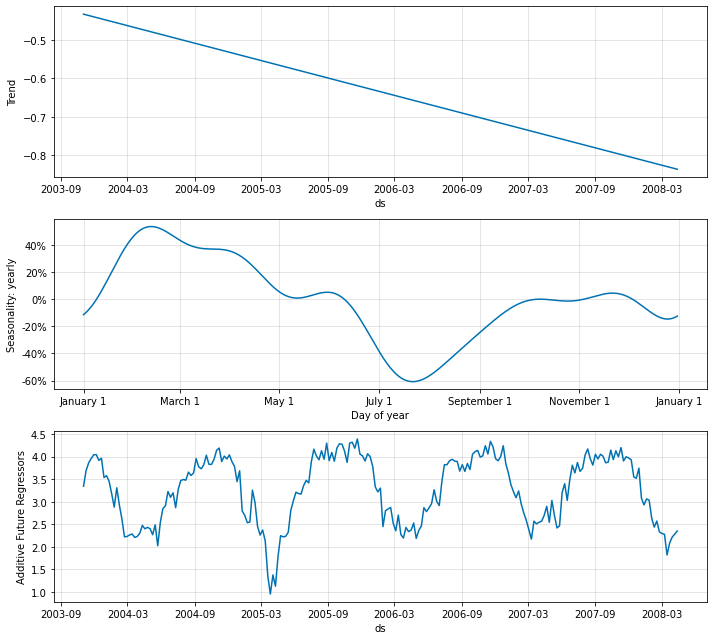

In [90]:
# diagnostic plots for predictions
fig_comp = sj_m_ex_log1.plot_components(sj_forecast_ex_log1)

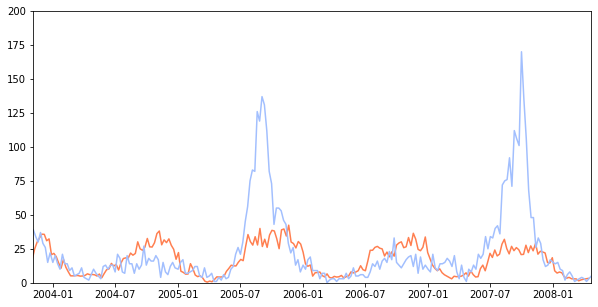

In [91]:
# get log-values back to normal scale
sj_pred_ex_log1 = np.exp(sj_forecast_ex_log1.yhat1)-1

# plot actual and predicted values
plt.plot(sj_forecast.ds, sj_pred_ex_log1, color=colors['predicted_weekly'])
plt.plot(sj_train_test.index, sj_train_test.total_cases, color=colors['actual_weekly'])
plt.xlim(sj_train_test.index[0], sj_train_test.index[-1]);
plt.ylim(0,200);

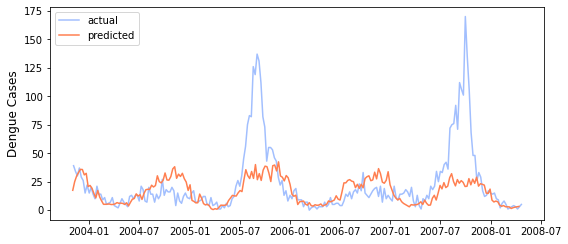

In [92]:
# plot for presentation
fig, ax = plt.subplots(figsize=(8, 3.5))

# plot actual and predicted values
plt.plot(sj_train_test.index, sj_train_test.total_cases, color=colors['actual_weekly'])
plt.plot(sj_forecast.ds, sj_pred_ex_log1, color=colors['predicted_weekly'])
ax.set_ylabel('Dengue Cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)
ax.legend(labels=['actual', 'predicted'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('plots/SJ_neuralprophet.png', dpi=200)

In [93]:
# model evaluation
model_classification(sj_train_test.total_cases, sj_pred_ex_log1)

--------------------
RMSE: 25.76
--------------------
MAE: 13.78
Explained variance: 0.231
--------------------


## Iquitos: Total cases (log-transformed)
### Feature selection

In [106]:
# get pearson correlation and get the 15 features with highest correlation
corr_mat = iq_train_train.corr()
cases_corr_list = (
    corr_mat['logged_cases']
    .drop(['logged_cases', 'total_cases', 'month', 'weekofyear', 'year'], axis=0)
    .abs()
    .sort_values(ascending=False)
)
cases_corr_list[:15]

reanalysis_specific_humidity_g_per_kg_lag3    0.268807
reanalysis_min_air_temp_c_lag3                0.263148
reanalysis_dew_point_temp_c_lag3              0.263113
reanalysis_min_air_temp_c_lag5                0.254312
reanalysis_min_air_temp_c_lag2                0.250560
reanalysis_min_air_temp_c_lag4                0.248600
reanalysis_specific_humidity_g_per_kg_lag5    0.247477
reanalysis_specific_humidity_g_per_kg_lag2    0.244054
reanalysis_dew_point_temp_c_lag5              0.243664
reanalysis_specific_humidity_g_per_kg_lag1    0.240043
reanalysis_dew_point_temp_c_lag2              0.236671
reanalysis_dew_point_temp_c_lag1              0.235764
reanalysis_min_air_temp_c_lag1                0.233546
reanalysis_specific_humidity_g_per_kg         0.232363
reanalysis_min_air_temp_c                     0.231066
Name: logged_cases, dtype: float64

In [107]:
# put 15 features with highest correlation in list
iq_exogs = cases_corr_list[:20].index.tolist()

### Setup model

In [108]:
# create prophet compatible dataframe
iq_prophet_df_ex_log1 = pd.DataFrame(iq_train_train.dropna().logged_cases).reset_index()
iq_prophet_df_ex_log1.columns = ['ds', 'y']
# add external variables (=future regressors)
iq_prophet_df_ex_log1 = pd.concat([iq_prophet_df_ex_log1, iq_train_train.dropna()[iq_exogs].reset_index()], axis=1)
iq_prophet_df_ex_log1 = iq_prophet_df_ex_log1.drop('index', axis=1)

In [109]:
# future regressors for forecast
iq_future_regressors_df1 = iq_train_test.dropna()[iq_exogs]

In [110]:
# setup and fit model 
iq_m_ex_log1 = NeuralProphet(n_changepoints=0,
                            epochs=100,
                            weekly_seasonality=False, 
                            daily_seasonality=False,
                            seasonality_mode='multiplicative',
                            seasonality_reg=50,
                            num_hidden_layers=2)

# add future regressors
for regressor in iq_exogs:
    iq_m_ex_log1 = iq_m_ex_log1.add_future_regressor(name=regressor)

metrics = iq_m_ex_log1.fit(iq_prophet_df_ex_log1, freq="W", validate_each_epoch=True)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-02
Epoch[100/100]: 100%|█| 100/100 [00:03<00:00, 25.60it/s, SmoothL1Loss=0.0257, MAE=0.674, RegLoss=1.67e-5, MAE_v


### Diagnostic plots

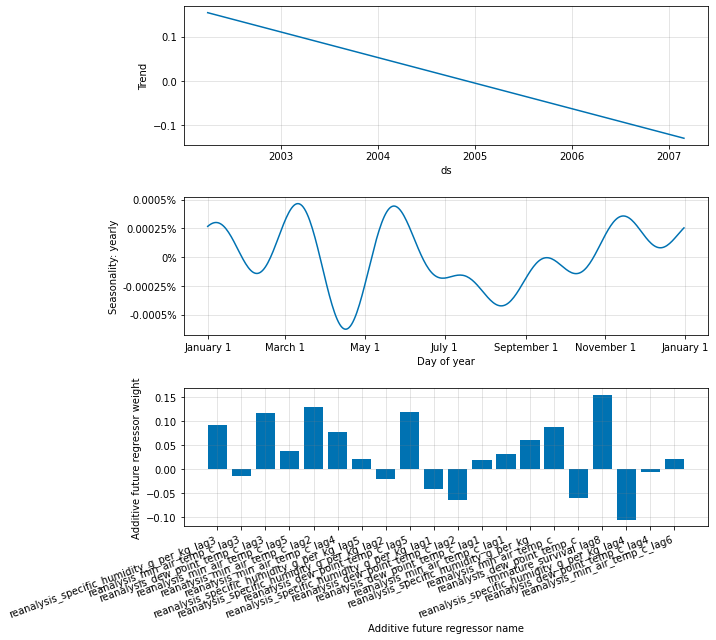

In [111]:
fig_param = iq_m_ex_log1.plot_parameters()

### Forecasting

In [112]:
# setup dataframe for forecasts
iq_future_ex_log1 = iq_m_ex_log1.make_future_dataframe(df=iq_prophet_df_ex_log1, regressors_df=iq_future_regressors_df1, periods=110)

# add actual values from train_test (not used, just for plotting)
iq_future_ex_log1['y'] = iq_prophet_df_test_log['y']

# make predictions
iq_forecast_ex_log1 = iq_m_ex_log1.predict(df=iq_future_ex_log1)

# convert negative values to zero (no negative prediction possible)
iq_forecast_ex_log1['yhat1'] = iq_forecast_ex_log1['yhat1'].clip(lower=0.0)

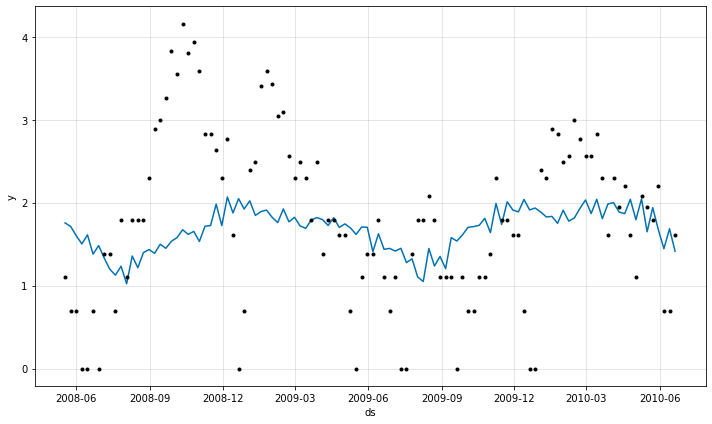

In [113]:
forecasts_plot = iq_m_ex_log1.plot(iq_forecast_ex_log1)

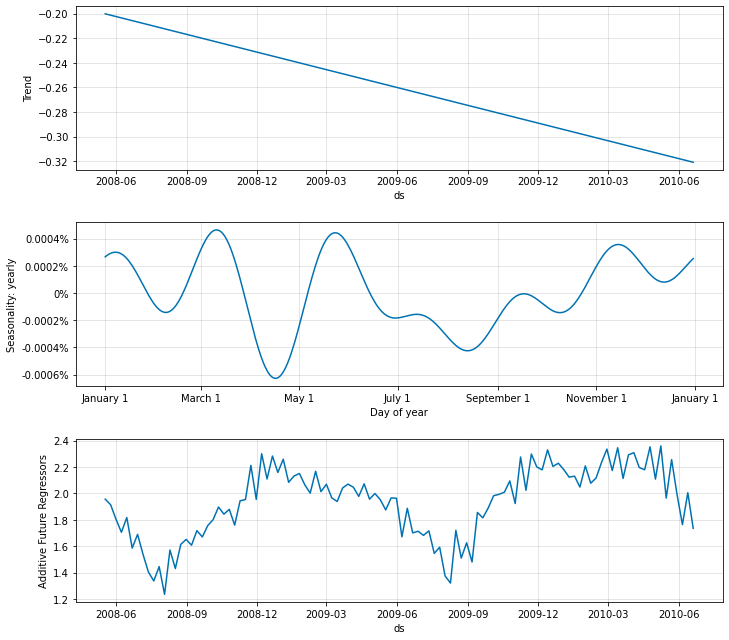

In [114]:
# diagnostic plots for predictions
fig_comp = iq_m_ex_log1.plot_components(iq_forecast_ex_log1)

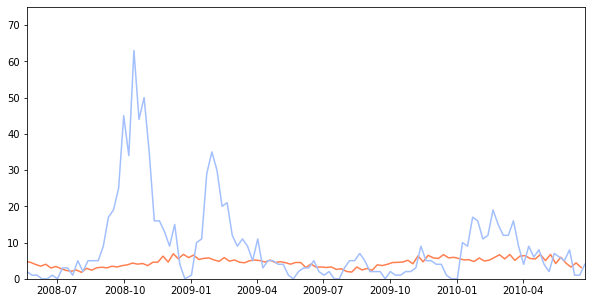

In [115]:
# get log-values back to normal scale
iq_pred_ex_log1 = np.exp(iq_forecast_ex_log1.yhat1)-1

# plot actual and predicted values
plt.plot(iq_forecast_ex.ds, iq_pred_ex_log1, color=colors['predicted_weekly'])
plt.plot(iq_train_test.index, iq_train_test.total_cases, color=colors['actual_weekly'])
plt.xlim(iq_train_test.index[0], iq_train_test.index[-1]);
plt.ylim(0,75);

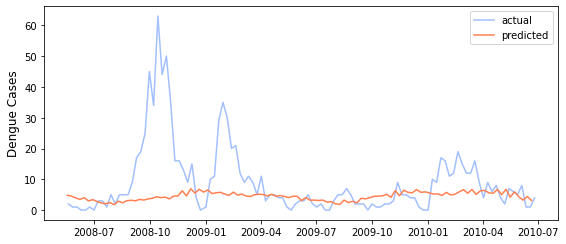

In [116]:
# plot for presentation
fig, ax = plt.subplots(figsize=(8, 3.5))

# plot actual values and predictions
plt.plot(iq_train_test.index, iq_train_test.total_cases, color=colors['actual_weekly'])
plt.plot(iq_forecast.ds, iq_pred_ex_log1, color=colors['predicted_weekly'])
ax.set_ylabel('Dengue Cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)
ax.legend(labels=['actual', 'predicted'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('plots/IQ_neuralprophet.png', dpi=200)

In [105]:
# model evaluation
model_classification(iq_train_test.total_cases, iq_pred_ex_log1)

--------------------
RMSE: 899051.07
--------------------
MAE: 198851.09
Explained variance: -6043323480.587
--------------------
